In [8]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy as sp

import pandas as pd
pd.options.display.max_rows = 20

In [9]:
from sklearn.datasets import load_boston
boston = load_boston(return_X_y=True)

In [17]:
X, y = boston

In [24]:
w0 = np.zeros_like(X[0])

In [84]:
def logit_loss_and_grad(w, X, y):
    explit = np.exp(-y * np.dot(X, w))
    loss = np.sum(np.log1p(explit))
    grad = np.dot(np.transpose(-y * (1 - 1 / (1 + explit))), X)
    
    return loss, grad

In [85]:
loss, grad = logit_loss_and_grad(w0, X, y)

In [90]:
(w, loss, info) = sp.optimize.fmin_l_bfgs_b(logit_loss_and_grad, w0, args=(X, y))

In [91]:
w

array([  4.67713166e-04,   3.08419447e-03,   2.04074377e-03,
         1.82079783e-05,   1.11480019e-04,   1.35222825e-03,
         1.34004637e-02,   8.36203768e-04,   1.70930918e-03,
         7.84329173e-02,   3.75567870e-03,   7.69741554e-02,
         2.19138084e-03])

In [92]:
loss

1.4906028712500531e-175

In [93]:
info

{'funcalls': 4,
 'grad': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'nit': 1,
 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
 'warnflag': 0}

In [98]:
np.sqrt(np.mean((y - np.dot(X, w))**2))

41.843989979034248

In [121]:
comp = np.array([y, np.dot(X, w)]).reshape((506, 2))

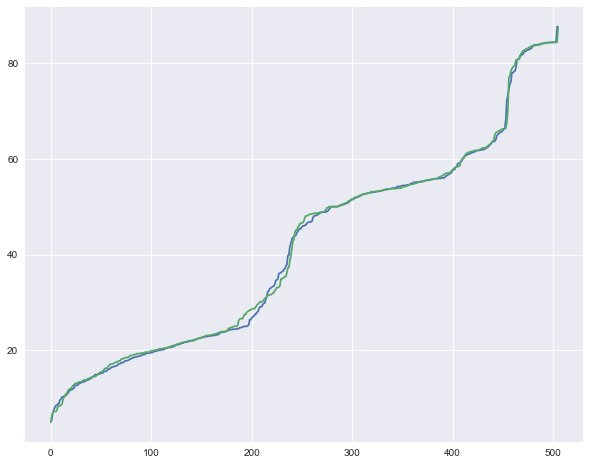

In [127]:
plt.figure(figsize=(10, 8))
plt.plot(np.sort(comp, axis=0))